# RandomForest

The objective of this exercise is to produce a model to predict positive moves (up trend) using machine learning
model. I will be following the 7-steps to model building  with the detailed feature engineering and model architecture.

| Steps    | Workflow  | Remarks |
| -------- | --------- | ------- |
| Step 1   | Ideation  | Predict next trading day price positive moves from the given dataset
| Step 2   | Data      | Collection Load the dataset from my github page
| Step 3   | Exploratory Data Analysis | Study summary statistics
| Step 4   | Cleaning Dataset | Data already cleaned, no further imputation required
| Step 5   | Transformation | Perform feature scaling based on EDA
| Step 6   | Modeling |Building and training Random forest classifier
| Step 7   | Metrics | Validating the model performance using score method

## Step 1 : Ideation

Predict next day price positive move (up trend) using RandomForest classifier.  

I will be using SPY index and data collected over 5 years 2018 - 2022 with a frquency of 1-day.


In [1]:
import time
start_time = time.time()

In [2]:
# Import libraries
# Base Libraries
import pandas as pd
import numpy as np
import pandas_ta as ta 

# Plotting
import matplotlib.pyplot as plt

import seaborn as sns

# data collection
import yfinance as yf 

#plt.rcParams['figure.figsize'] = (20,7)
#plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# plt.style.use('fivethirtyeight')
# Preprocessing
from sklearn import tree
from sklearn.model_selection import (
                                        train_test_split,
                                        GridSearchCV,
                                        RandomizedSearchCV,
                                        TimeSeriesSplit,
                                        cross_val_score
                                        )
# Classifier
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import (   RocCurveDisplay,
                                ConfusionMatrixDisplay
                                )
from sklearn.metrics import (classification_report,
                             accuracy_score,
                            f1_score,
                                )

# for pretty print parameters
from pprint import pprint

# Feature importance
import shap
# Return Analysis
import pyfolio as pf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Flag to save plots
save_plot = True


Module "zipline.assets" not found; multipliers will not be applied to position notionals.


## Step 2 : Data collection

Collected over 10 years 2012 - 2022 with a frquency of 1-day.


In [3]:
start_date = '2018-01-01' 
end_date = '2022-12-31'
live_start_date = '2022-01-01'
random_seed = 23

df = yf.download('SPY', start=start_date, end=end_date, progress=False)


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02 00:00:00-05:00,267.839996,268.809998,267.399994,268.769989,244.057770,86655700
2018-01-03 00:00:00-05:00,268.959991,270.640015,268.959991,270.470001,245.601501,90070400
2018-01-04 00:00:00-05:00,271.200012,272.160004,270.540009,271.609985,246.636734,80636400
2018-01-05 00:00:00-05:00,272.510010,273.559998,271.950012,273.420013,248.280289,83524000
2018-01-08 00:00:00-05:00,273.309998,274.100006,272.980011,273.920013,248.734314,57319200
...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,378.706665,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,377.213226,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,372.525238,70911500


## Step 3 : Exploratory data analysis


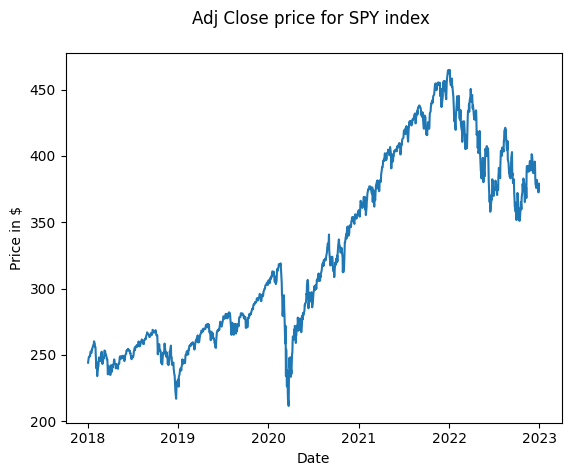

In [5]:
plt.plot(df['Adj Close'])
plt.title("Adj Close price for SPY index \n")
plt.xlabel("Date")
plt.ylabel("Price in $")

if save_plot:
    plt.savefig('adj close plot.png')

plt.show()

Here we plotted the Adjusted close price of the index and it looks like the data is formatted correctly.

Lets check the shape or dimensions of our dataset.

In [6]:
df.shape

(1259, 6)

Now lets check for any null values in the columns

In [7]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

We have Open, Close, High, Low, Adj Close and Volume from out data. I will be adding more parameters which are derived from these to better model our data. 
I will be adding the following features to begin with.

|N | Feature | Description |
|--|---------|-------------|
|1.| Sign | Sign of returns.
|2.| PS | Price strength (close - Low)/(High-Low)
|3.| GAP | Open/previous close -1
|4.|PCHG day(2,3,5,7,14)| Fractional change between the current and ith Close price
|5.|VCHG day(2,3,5,7,14)| Fractional change between the current and ith Volume 
|6.|RET  day(2,3,5,7,14)| Rolling sum of returns for i days
|7.|MA   day(2,3,5,7,14)| Ratio of current Close price to rolling mean of Close for i days
|8.|VMA  day(2,3,5,7,14)| Ratio of current Volume to rolling mean of Volume for i days
|9.|OC   day(2,3,5,7,14)| Rolling mean of OC for i days
|10.|HC   day(2,3,5,7,14)| Rolling mean of HC for i days
|11.|GAP  day(2,3,5,7,14)| Rolling mean of GAP for i days
|12.|STD  day(2,3,5,7,14)| Rolling standard deviation of returns for i days
|13.|RSI_indicator   day(2,3,5,7)| The relative strength index over i days. Overbought when above 70 and oversold when below 30. 
|14.|Willr   day(2,3,5,7)| William %R indicator for i days. Above -20 is overbought, above below -80 is oversold.
|15.|ADX_direction   day(2,3,5,7)| Average Directional Index direction. 
|16.|ADX   day(2,3,5,7)| Average Directional Index. 
|17.|OBV day(2,3,5,7) | On-Balance Volume

In [8]:
df1 = df.copy()


df1['Returns'] = np.log(df1['Adj Close'] / df1['Adj Close'].shift())

df1['Sign'] = np.sign(df1['Returns'])

multiplier = 1.5
# features
df1['OC'] = df1['Close'] / df1['Open'] - 1
df1['HL'] = df1['High'] / df1['Low'] - 1
df1['PS'] = (df1.Close - df1.Low) / (df1.High - df1.Low)
df1['GAP'] = df1['Open'] / df1['Close'].shift(1) - 1

for i in [2, 3, 5, 7, 14]:
    df1['PCHG' + str(i)] = df1['Close'].pct_change(i)
    df1['VCHG' + str(i)] = df1['Volume'].pct_change(i)
    df1['RET' + str(i)] = df1['Returns'].rolling(i).sum()
    df1['MA' + str(i)] = df1['Close'] / df1['Close'].rolling(i).mean()
    df1['VMA' + str(i)] = df1['Volume'] / df1['Volume'].rolling(i).mean()
    df1['OC'+ str(i)] = df1['OC'].rolling(i).mean()
    df1['HL'+ str(i)] = df1['HL'].rolling(i).mean()
    df1['GAP'+ str(i)] = df1['GAP'].rolling(i).mean()
    df1['STD'+ str(i)] = df1['Returns'].rolling(i).std()

# Drop NaN values
df1.dropna(inplace=True)
df1.drop(columns=['OC', 'HL'], inplace=True) 


for window_length in [2, 3, 5, 7]:
    # Relative strength index
    df1['RSI']  = ta.rsi(df1['Close'], length=window_length)
    df1['RSI_indictor_'+str(window_length)] = pd.cut(df1['RSI'] ,[0, 30, 100],labels=[1, 0])

    # William %R 
    df1['William %R'] = ta.willr(df1['High'], df1['Low'], df1['Close'], length=window_length)
    df1['Willr_'+str(window_length)] = pd.cut(df1['William %R'] ,[-100, -80, 0],labels=[1, 0])
    df1.drop(columns=['William %R', 'RSI'], inplace=True)
    
    # Average Directional Index       ADX              
    adx = ta.adx(df1['High'], df1['Low'], df1['Close'], length = window_length)
    df1['ADX_direction_'+str(window_length)] = np.where(adx['DMP_'+str(window_length)] > adx['DMN_'+str(window_length)], 1, 0) 
    df1['ADX_'+str(window_length)] = adx['ADX_'+str(window_length)] / 100
    df1['OBV'+str(window_length)] = ta.obv(df1['Close'], df1['Volume'], offset=window_length) / 1e9
                         

In [9]:
df1.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Sign,PS,GAP,...,RSI_indictor_5,Willr_5,ADX_direction_5,ADX_5,OBV5,RSI_indictor_7,Willr_7,ADX_direction_7,ADX_7,OBV7
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-23 00:00:00-05:00,282.739990,283.619995,282.369995,283.290009,257.242706,97084700,0.002120,1.0,0.736011,0.000177,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-24 00:00:00-05:00,284.019989,284.700012,281.839996,283.179993,257.142975,134816100,-0.000388,-1.0,0.468528,0.002577,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-25 00:00:00-05:00,284.160004,284.269989,282.399994,283.299988,257.251801,84587300,0.000423,1.0,0.481281,0.003461,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-26 00:00:00-05:00,284.250000,286.630005,283.959991,286.579987,260.230255,107743100,0.011511,1.0,0.981267,0.003353,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-29 00:00:00-05:00,285.929993,286.429993,284.500000,284.679993,258.504822,90118300,-0.006652,-1.0,0.093261,-0.002268,...,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN


In [10]:
df1

,Open,High,Low,Close,Adj Close,Volume,Returns,Sign,PS,GAP,...,RSI_indictor_5,Willr_5,ADX_direction_5,ADX_5,OBV5,RSI_indictor_7,Willr_7,ADX_direction_7,ADX_7,OBV7
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-23 00:00:00-05:00,282.739990,283.619995,282.369995,283.290009,257.242706,97084700,0.002120,1.0,0.736011,0.000177,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-24 00:00:00-05:00,284.019989,284.700012,281.839996,283.179993,257.142975,134816100,-0.000388,-1.0,0.468528,0.002577,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-25 00:00:00-05:00,284.160004,284.269989,282.399994,283.299988,257.251801,84587300,0.000423,1.0,0.481281,0.003461,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-26 00:00:00-05:00,284.250000,286.630005,283.959991,286.579987,260.230255,107743100,0.011511,1.0,0.981267,0.003353,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-29 00:00:00-05:00,285.929993,286.429993,284.500000,284.679993,258.504822,90118300,-0.006652,-1.0,0.093261,-0.002268,...,NaN,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,378.706665,59857300,0.005736,1.0,0.970180,-0.002810,...,0,0,0,0.321024,-2.238105,0,0,0,0.245485,-2.000541
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,377.213226,51638200,-0.003951,-1.0,0.500000,-0.000313,...,0,0,0,0.331913,-2.317983,0,0,0,0.254853,-2.118247
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,372.525238,70911500,-0.012506,-1.0,0.034432,-0.000184,...,1,1,0,0.366173,-2.243556,0,1,0,0.276292,-2.238105


In [11]:
df1.isnull().sum()


Open                0
High                0
Low                 0
Close               0
Adj Close           0
                   ..
RSI_indictor_7      7
Willr_7             8
ADX_direction_7     0
ADX_7              13
OBV7                7
Length: 75, dtype: int64

Lets check the dimensions of our data again with the new parameters.

In [12]:
df1.shape    

(1245, 75)

In [13]:
# Descriptive statistics
df1.describe()

,Open,High,Low,Close,Adj Close,Volume,Returns,Sign,PS,GAP,...,OBV2,ADX_direction_3,ADX_3,OBV3,ADX_direction_5,ADX_5,OBV5,ADX_direction_7,ADX_7,OBV7
count,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000,...,1243.000000,1245.000000,1240.000000,1242.000000,1245.000000,1236.000000,1240.000000,1245.000000,1232.000000,1238.000000
mean,345.114257,347.305413,342.679422,345.110819,328.820718,8.721282e+07,0.000311,0.083534,0.552556,0.000300,...,-0.047375,0.553414,0.511629,-0.045539,0.547791,0.393274,-0.042013,0.548594,0.331166,-0.038502
std,66.556268,66.834330,66.206005,66.566515,70.316114,4.603280e+07,0.013693,0.995695,0.315407,0.008911,...,0.880576,0.497339,0.159207,0.878547,0.497911,0.126876,0.874851,0.497833,0.107996,0.871176
min,228.190002,229.679993,218.259995,222.949997,211.438675,2.027000e+07,-0.115886,-1.000000,0.000000,-0.104485,...,-2.359324,0.000000,0.161685,-2.359324,0.000000,0.111488,-2.359324,0.000000,0.101670,-2.359324
25%,285.140015,286.429993,283.200012,285.059998,264.689362,5.772790e+07,-0.005243,-1.000000,0.263380,-0.002856,...,-0.562846,0.000000,0.391448,-0.562615,0.000000,0.297084,-0.557634,0.000000,0.249236,-0.554006
50%,328.279999,330.059998,326.399994,328.730011,312.288025,7.576780e+07,0.000728,1.000000,0.576325,0.000658,...,-0.109635,1.000000,0.495967,-0.108831,1.000000,0.374375,-0.106545,1.000000,0.316783,-0.105063
75%,404.489990,407.239990,401.540009,405.410004,395.336273,1.023501e+08,0.007088,1.000000,0.848129,0.004049,...,0.649519,1.000000,0.613843,0.649884,1.000000,0.469659,0.650888,1.000000,0.398908,0.652163
max,479.220001,479.980011,476.059998,477.709991,464.923401,3.922207e+08,0.086731,1.000000,1.000000,0.060376,...,1.813762,1.000000,0.973351,1.813762,1.000000,0.846932,1.813762,1.000000,0.758812,1.813762


## Cleaning & Imputation

In [14]:
# Check for missing values
df1.dropna(inplace=True)
df1.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
                  ..
RSI_indictor_7     0
Willr_7            0
ADX_direction_7    0
ADX_7              0
OBV7               0
Length: 75, dtype: int64

## Feature Specification
Features or Predictors are also known as an independent variable which are used to determine the
value of the target variable. 

In [15]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Sign', 'PS', 'GAP', 'PCHG2', 'VCHG2', 'RET2', 'MA2', 'VMA2', 'OC2',
       'HL2', 'GAP2', 'STD2', 'PCHG3', 'VCHG3', 'RET3', 'MA3', 'VMA3', 'OC3',
       'HL3', 'GAP3', 'STD3', 'PCHG5', 'VCHG5', 'RET5', 'MA5', 'VMA5', 'OC5',
       'HL5', 'GAP5', 'STD5', 'PCHG7', 'VCHG7', 'RET7', 'MA7', 'VMA7', 'OC7',
       'HL7', 'GAP7', 'STD7', 'PCHG14', 'VCHG14', 'RET14', 'MA14', 'VMA14',
       'OC14', 'HL14', 'GAP14', 'STD14', 'RSI_indictor_2', 'Willr_2',
       'ADX_direction_2', 'ADX_2', 'OBV2', 'RSI_indictor_3', 'Willr_3',
       'ADX_direction_3', 'ADX_3', 'OBV3', 'RSI_indictor_5', 'Willr_5',
       'ADX_direction_5', 'ADX_5', 'OBV5', 'RSI_indictor_7', 'Willr_7',
       'ADX_direction_7', 'ADX_7', 'OBV7'],
      dtype='object')

Lets check the correlaion between our features. We will drop highly correlated (correlation > 0.9) features.

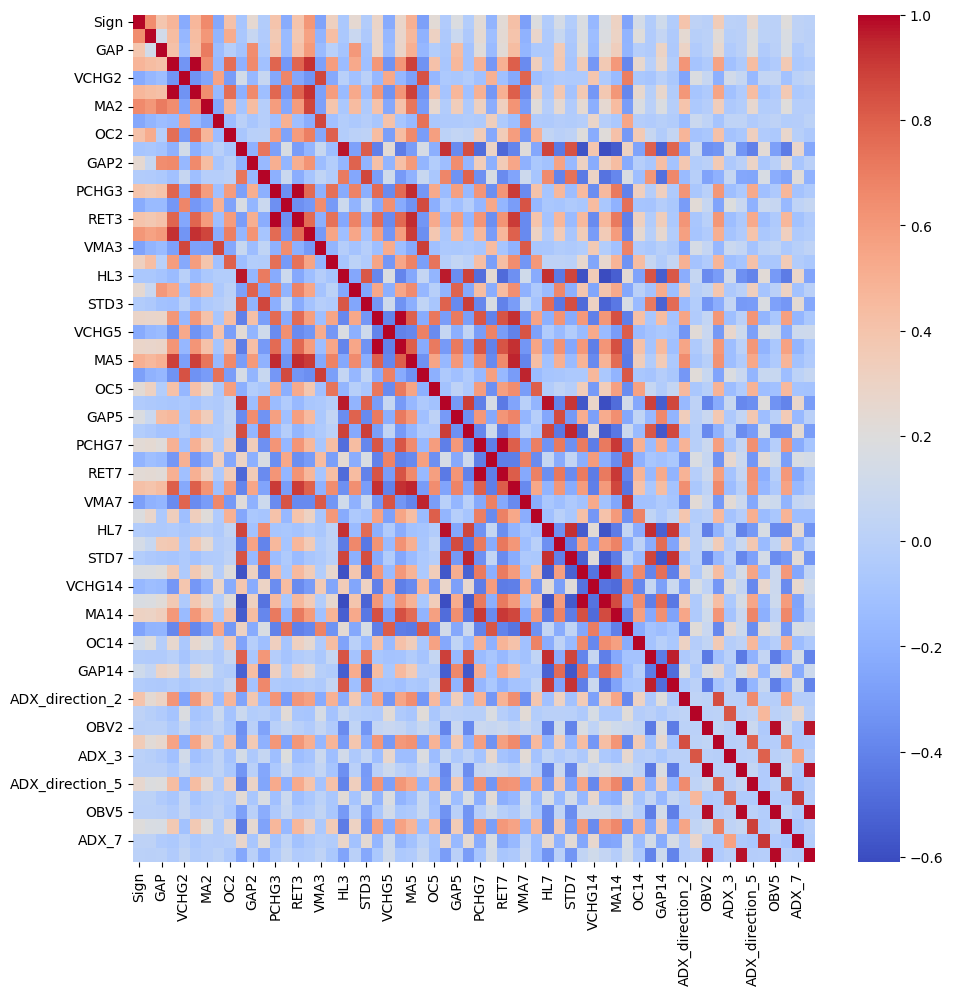

In [16]:
corr = df1.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns'], axis=1).corr()
plt.figure(figsize=(11,11))
sns.heatmap(corr, cmap="coolwarm")

if save_plot:
    plt.savefig('feature corr plot.png')

plt.show()

Which features have correlation > 0.9?

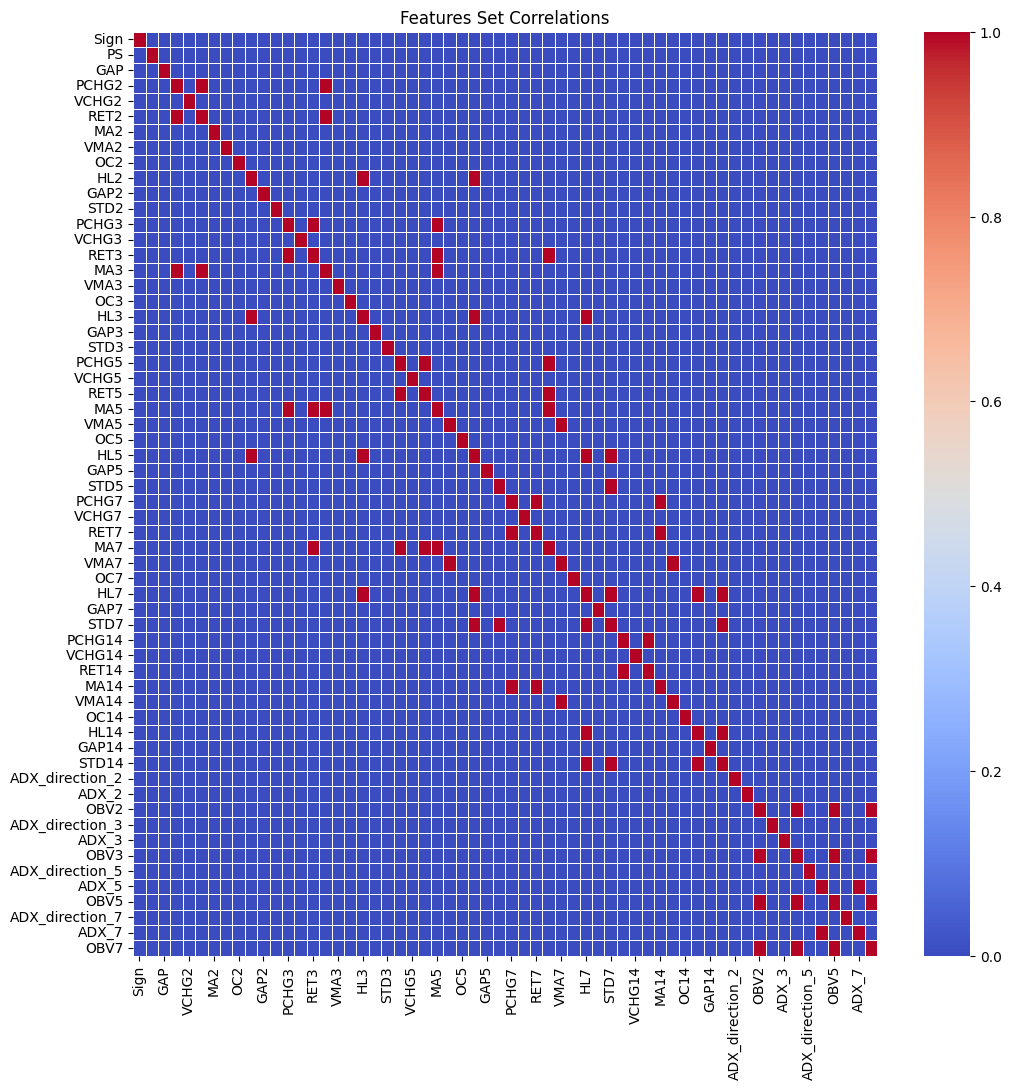

In [17]:
# drop label from dataframe
df1_corr = df1.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns'], axis=1)

# remove features that are highly correlated
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df1_corr.corr()>0.9,
            linewidth=.5,
            cmap="coolwarm",
            cbar=True); #cmap="crest", virids, magma
plt.title('Features Set Correlations')


if save_plot:
    plt.savefig('highly correlated fetures plot.png')

plt.show()

In [18]:
# remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [19]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

df1 = clean_dataset(df1)

In [20]:
df1_corr.columns

Index(['Sign', 'PS', 'GAP', 'PCHG2', 'VCHG2', 'RET2', 'MA2', 'VMA2', 'OC2',
       'HL2', 'GAP2', 'STD2', 'PCHG3', 'VCHG3', 'RET3', 'MA3', 'VMA3', 'OC3',
       'HL3', 'GAP3', 'STD3', 'PCHG5', 'VCHG5', 'RET5', 'MA5', 'VMA5', 'OC5',
       'HL5', 'GAP5', 'STD5', 'PCHG7', 'VCHG7', 'RET7', 'MA7', 'VMA7', 'OC7',
       'HL7', 'GAP7', 'STD7', 'PCHG14', 'VCHG14', 'RET14', 'MA14', 'VMA14',
       'OC14', 'HL14', 'GAP14', 'STD14', 'RSI_indictor_2', 'Willr_2',
       'ADX_direction_2', 'ADX_2', 'OBV2', 'RSI_indictor_3', 'Willr_3',
       'ADX_direction_3', 'ADX_3', 'OBV3', 'RSI_indictor_5', 'Willr_5',
       'ADX_direction_5', 'ADX_5', 'OBV5', 'RSI_indictor_7', 'Willr_7',
       'ADX_direction_7', 'ADX_7', 'OBV7'],
      dtype='object')

Now we will drop first items from the pairs of correlated features.

In [21]:
# total correlated features
drop_correlated_features = correlated_features(df1_corr)

# drop the highly correlated features
X = df1.drop(drop_correlated_features, axis=1)
X = X.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns'], axis=1, errors='ignore')

# record feature names
feature_names = X.columns
feature_names

Index(['Sign', 'PS', 'GAP', 'PCHG2', 'VCHG2', 'MA2', 'VMA2', 'OC2', 'HL2',
       'GAP2', 'STD2', 'PCHG3', 'VCHG3', 'VMA3', 'OC3', 'GAP3', 'STD3',
       'PCHG5', 'VCHG5', 'VMA5', 'OC5', 'GAP5', 'STD5', 'PCHG7', 'VCHG7',
       'OC7', 'GAP7', 'PCHG14', 'VCHG14', 'OC14', 'GAP14', 'RSI_indictor_2',
       'Willr_2', 'ADX_direction_2', 'ADX_2', 'OBV2', 'RSI_indictor_3',
       'Willr_3', 'ADX_direction_3', 'ADX_3', 'RSI_indictor_5', 'Willr_5',
       'ADX_direction_5', 'ADX_5', 'RSI_indictor_7', 'Willr_7',
       'ADX_direction_7'],
      dtype='object')

This list will be our features. 

In [22]:
# Output first five values
X.head()

,Sign,PS,GAP,PCHG2,VCHG2,MA2,VMA2,OC2,HL2,GAP2,...,Willr_3,ADX_direction_3,ADX_3,RSI_indictor_5,Willr_5,ADX_direction_5,ADX_5,RSI_indictor_7,Willr_7,ADX_direction_7
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-09 00:00:00-05:00,1.0,0.802620,0.012304,-0.023051,0.694180,1.007455,1.070028,-0.018023,0.041670,0.006787,...,0.0,0.0,0.804601,1.0,0.0,0.0,0.737351,1.0,0.0,0.0
2018-02-12 00:00:00-05:00,1.0,0.687848,0.008910,0.029927,-0.416773,1.007289,0.672762,0.004204,0.031356,0.010607,...,0.0,0.0,0.679240,0.0,0.0,0.0,0.697970,0.0,0.0,0.0
2018-02-13 00:00:00-05:00,1.0,0.812690,-0.005163,0.017208,-0.713563,1.001242,0.722117,0.006707,0.016509,0.001873,...,0.0,0.0,0.596205,0.0,0.0,0.0,0.668130,0.0,0.0,0.0
2018-02-14 00:00:00-05:00,1.0,0.928070,-0.006353,0.016017,-0.160018,1.006703,1.195644,0.013833,0.017069,-0.005758,...,0.0,1.0,0.414658,0.0,0.0,0.0,0.582443,0.0,0.0,0.0
2018-02-15 00:00:00-05:00,1.0,0.997656,0.007345,0.026429,0.369064,1.006340,0.958888,0.012676,0.018727,0.000496,...,0.0,1.0,0.393161,0.0,0.0,0.0,0.469421,0.0,0.0,0.0


In [23]:
print('Number of features after cleaning = {}'.format(len(X.columns)))

Number of features after cleaning = 47


In [24]:
# decide which scaling to use
X.describe()

,Sign,PS,GAP,PCHG2,VCHG2,MA2,VMA2,OC2,HL2,GAP2,...,Willr_3,ADX_direction_3,ADX_3,RSI_indictor_5,Willr_5,ADX_direction_5,ADX_5,RSI_indictor_7,Willr_7,ADX_direction_7
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,...,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,0.089504,0.555855,0.000346,0.000847,0.062964,1.000192,0.999054,0.000093,0.013684,0.000340,...,0.179821,0.558991,0.509989,0.120423,0.157038,0.554923,0.392251,0.076485,0.150529,0.554923
std,0.995165,0.313766,0.008930,0.017601,0.401333,0.006806,0.151067,0.006655,0.009844,0.005792,...,0.384195,0.496710,0.158373,0.325588,0.363985,0.497177,0.125980,0.265881,0.357735,0.497177
min,-1.000000,0.000839,-0.104485,-0.139761,-0.862242,0.942121,0.529550,-0.039787,0.001885,-0.052639,...,0.000000,0.000000,0.161685,0.000000,0.000000,0.000000,0.111488,0.000000,0.000000,0.000000
25%,-1.000000,0.271194,-0.002829,-0.007312,-0.204849,0.997379,0.895016,-0.003046,0.007041,-0.001861,...,0.000000,0.000000,0.390166,0.000000,0.000000,0.000000,0.296736,0.000000,0.000000,0.000000
50%,1.000000,0.578945,0.000685,0.002352,-0.009922,1.000369,0.994138,0.000576,0.010950,0.000712,...,0.000000,1.000000,0.494232,0.000000,0.000000,1.000000,0.373741,0.000000,0.000000,1.000000
75%,1.000000,0.848929,0.004103,0.010415,0.227156,1.003598,1.097478,0.003446,0.017372,0.002819,...,0.000000,1.000000,0.611833,0.000000,0.000000,1.000000,0.468809,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.060376,0.106930,2.697124,1.043338,1.492572,0.032971,0.087355,0.037092,...,1.000000,1.000000,0.973351,1.000000,1.000000,1.000000,0.846932,1.000000,1.000000,1.000000


Lets check how the features values varies.

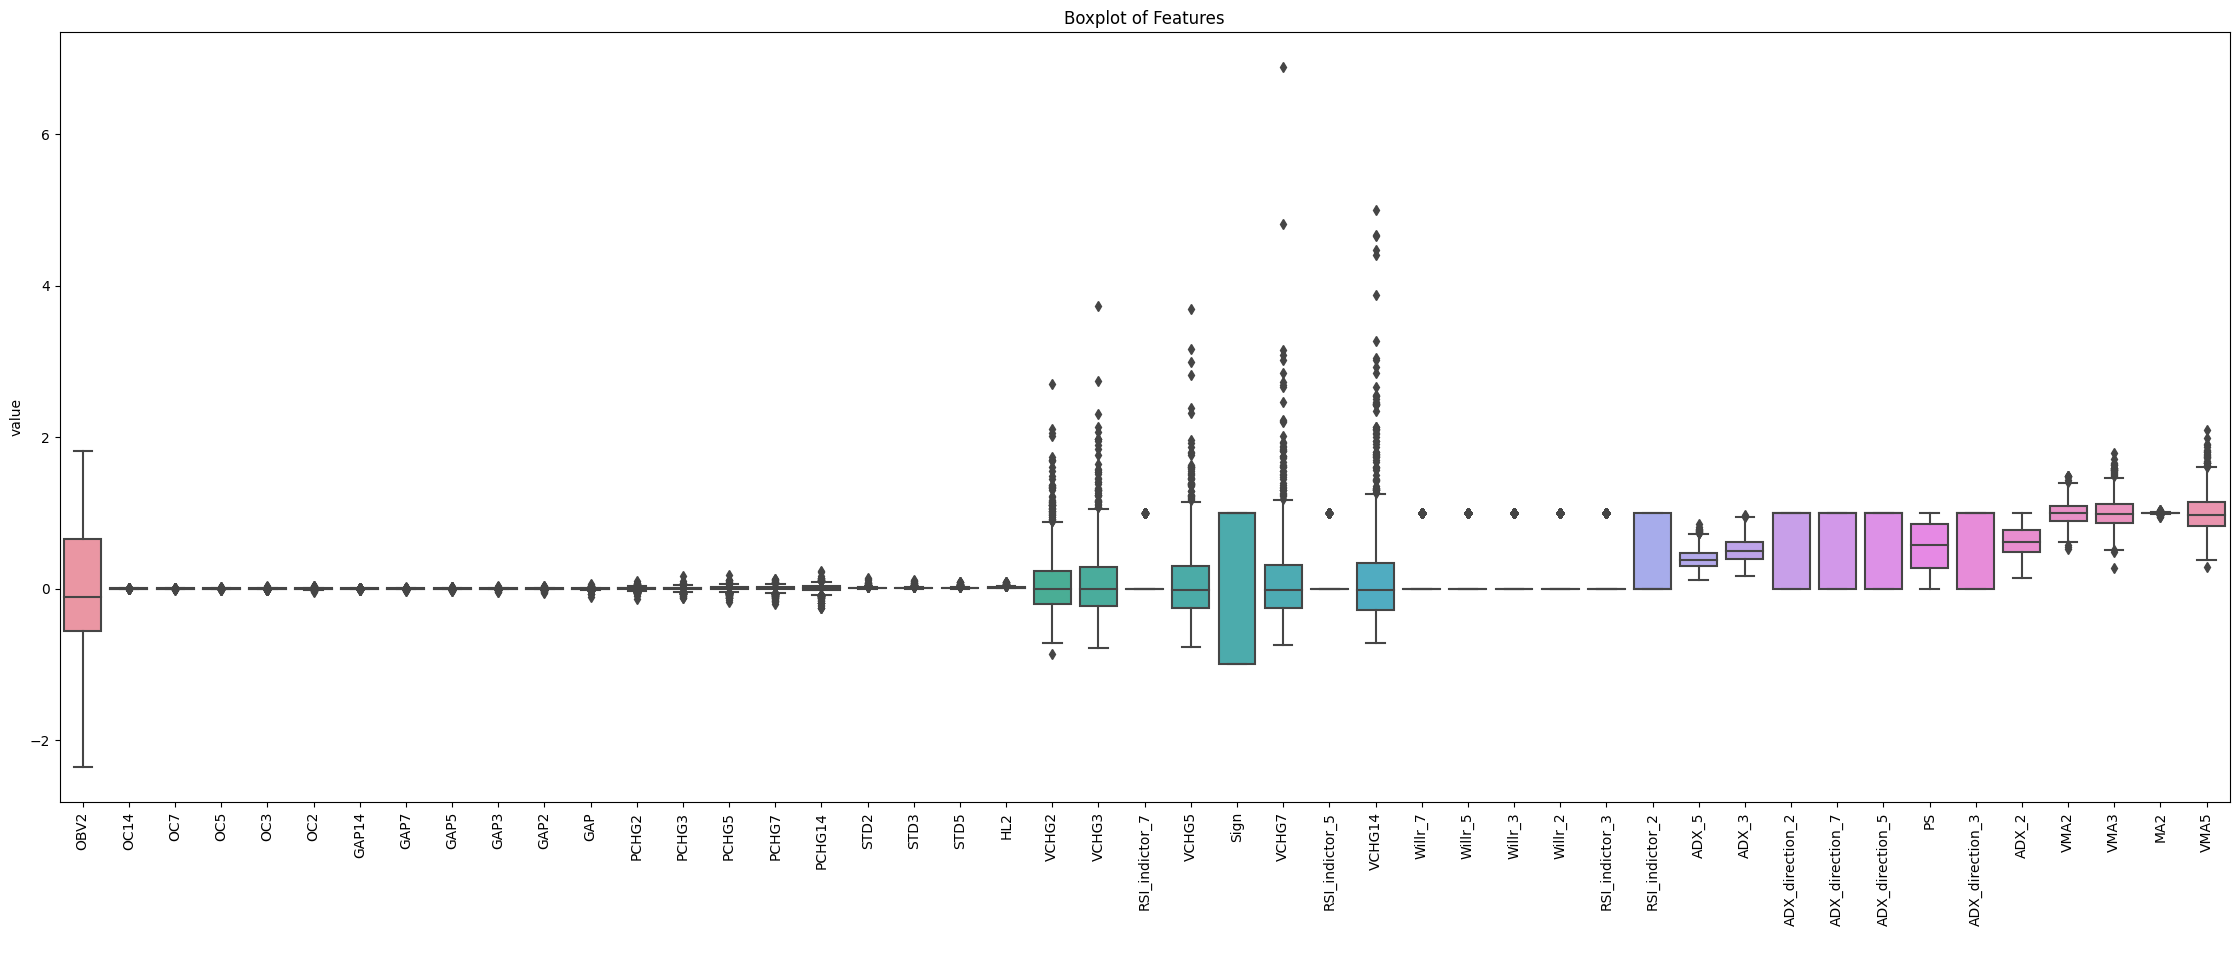

In [25]:
# study the distribution

df_boxplot = pd.melt(X)

fig, ax = plt.subplots(figsize=(28,10))
ax.tick_params(axis='x', labelrotation=90)
sns.boxplot(x='variable', y='value', data=df_boxplot, order=df_boxplot.groupby(by=['variable']).mean().sort_values(by='value').index)
plt.xlabel(' ')
plt.title('Boxplot of Features')


if save_plot:
    plt.savefig('boxplot of features plot.png')

plt.show()

All features are within -3 and +7. ADX was divided by 100 and OBV by $10^9$ to bring them to the same scale.

## Target or Label Definition
Label or the target variable is also known as the dependent variable. Here, the target variable is
whether SPY Index price will close up or down on the next trading day. If the tomorrow’s closing
price is greater than the 1.0025 of today’s closing price, then we will buy the Nifty, else we will sell
the index.
We assign a value of +1 for the buy signal and 0 for the sell signal to target variable. The target
can be described as :
$$ y_t = \begin{cases} +1, & \text{if} & p_{t+1} > 1.0025 ∗ pt \\
0, & \text{if} & p_{t+1}  Otherwise\end{cases}
$$
whre, $p_t$ is the current closing price of SPY Index and $p_{t+1}$ is the 1-day forward closing price of the
index.

In [26]:
# Target- Avoid using [-1, 1], always prefer [0, 1] as class labels
y = np.where(df1['Returns'].shift(-1) > 1.0025 * df1['Returns'], 1, 0 )

y

array([0, 0, 1, ..., 1, 0, 0])

In [27]:
# Value counts for class 1 and -1
pd.Series(y).value_counts()

0    634
1    595
dtype: int64

In [28]:
Class_1 = pd.Series(y).value_counts()[1]
Class_0 = pd.Series(y).value_counts()[0]
percent_1 = round(100*(Class_1)/(Class_1 + Class_0),1)
percent_0 = 100 - percent_1
print('Percent for class 1 = {}% and for class 1 = {}%'.format(percent_1, percent_0))
print('Classes are different by {}%'.format(round(100*(Class_0 - Class_1)/Class_1, 2)))

Percent for class 1 = 48.4% and for class 1 = 51.6%
Classes are different by 6.55%


Here they sample is out of balance, but by not so much. We have 6% more samples in '1' or samples with less than 0.25% positive returns.

## Step 5 : Transformation
Random Forest is a tree-based model and hence does not require feature scaling. Tree-based models are invariant to the scale of the features, which makes them very user-friendly as this step can be skipped during preprocessing

## Split Data

In [29]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=random_seed)
# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 983, 246


## Step 6 Modeling

### Base Model
We now build a base model with default parameters. 

Fit model

In [30]:
X_train.dropna(inplace=True)


In [31]:
 # Scale and fit the model
model =  RandomForestClassifier(random_state=random_seed)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=23)

In [32]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 23,
 'verbose': 0,
 'warm_start': False}


Predict model

In [33]:
# Predict Model
# Predicting the test dataset
y_pred = model.predict(X_test)
# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [34]:
# verify the class labels
model.classes_

array([0, 1])

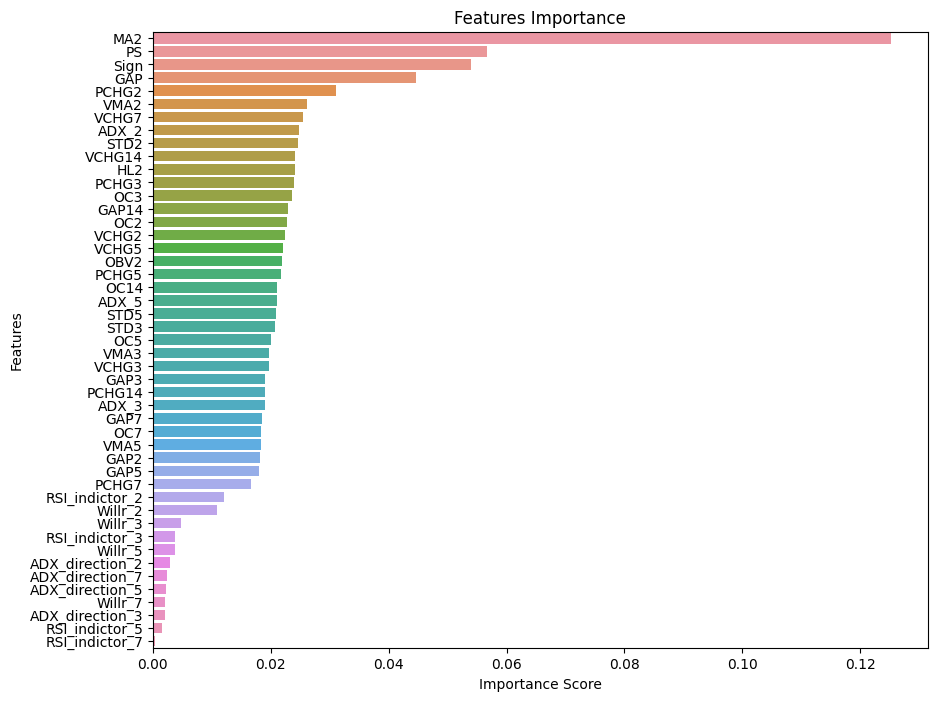

In [35]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': model.feature_importances_,'Features': feature_names}).sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance')

if save_plot:
    plt.savefig('Features Importance plot.png')

plt.show()

In [36]:
y_pred[-20:]

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0])

In [37]:
# predict probability
y_proba[-20:]

array([[0.49, 0.51],
       [0.16, 0.84],
       [0.23, 0.77],
       [0.38, 0.62],
       [0.71, 0.29],
       [0.3 , 0.7 ],
       [0.78, 0.22],
       [0.69, 0.31],
       [0.34, 0.66],
       [0.24, 0.76],
       [0.2 , 0.8 ],
       [0.31, 0.69],
       [0.53, 0.47],
       [0.7 , 0.3 ],
       [0.34, 0.66],
       [0.66, 0.34],
       [0.37, 0.63],
       [0.18, 0.82],
       [0.84, 0.16],
       [0.6 , 0.4 ]])

In [38]:
# predict class labels
y_pred[-20:]

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0])

Accuracy score of our base model

In [39]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 1.0, Test Accuracy: 0.7358


Test data is 100% accurate while test data has way low accuracy. This is because of overfitting. We can overcome overfitting by tuning our hyperparameters.

## Prediction Quality
Confusion Matrix  

Confusion matrix is a table used to describe the performance of a classification model on a set of
test data for which the true values are known.

| Outcome | Position1  |
| ------- | --------- |
| True Negative | upper-left |
| False Negative | lower-left |
| False Positive | upper-right |
| True Positive | lower-right |

True Positive is an outcome where the model correctly predicts the positive class. Similarly, a
true negative is an outcome where the model correctly predicts the negative class.


False Positive is an outcome where the model incorrectly predicts the positive class. And a false
negative is an outcome where the model incorrectly predicts the negative class.



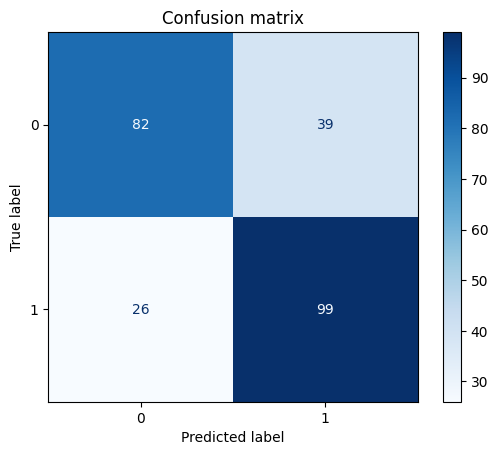

In [40]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
                                                model,
                                                X_test,
                                                y_test,
                                                display_labels=model.classes_,
                                                cmap=plt.cm.Blues
                                                )
plt.title('Confusion matrix')
if save_plot:
    plt.savefig('Confusion matrix Base plot.png')

plt.show()

## Classification Report
A classification report is used to measure the quality of predictions from a classification algorithm

In [41]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       121
           1       0.72      0.79      0.75       125

    accuracy                           0.74       246
   macro avg       0.74      0.73      0.73       246
weighted avg       0.74      0.74      0.73       246



Macro Average Average of precision (or recall or f1-score) of different classes. 

Weighted Average Actual Class1 instance * precision (or recall or f1-score) of Class1 + Actual
Class2 instance * (or recall or f1-score) of Class2. 

## Receiver Operator Characteristic Curve (ROC)
The area under the ROC curve (AUC) is a measure of how well a model can distinguish between
two classes. The ROC curve is created by plotting the true positive rate (TPR) against the false
positive rate (FPR) at various classification thresholds.

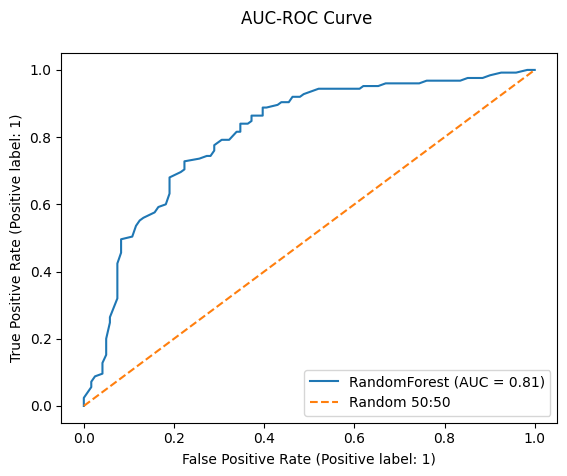

In [42]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
                                        model,
                                        X_test,
                                        y_test,
                                        name='RandomForest')

plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
if save_plot:
    plt.savefig('AUC-ROC Curve Base plot.png')

plt.show()

## Hyper-parameter Tuning
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they
are passed as arguments to the constructor of the estimator classes. It is possible and recommended
to search the hyper-parameter space for the best cross validation score. Any parameter provided
when constructing an estimator may be optimized in this manner.


## Cross-validation of Time Series
Time series data are sequential in nature and are characterised by the correlation between observa-
tions. Classical cross-validation techniques such as KFold assume the samples are independent and
identically distributed, and would result in poor estimates when applied on time series data.
To preserve the order and have training set occur prior to the test set, we use Forward Chaining
method in which the model is initially trained and tested with the same windows size. And, for
each subsequent fold, the training window increases in size, encompassing both the previous training
data and test data. The new test window once again follows the training window but stays the
same length.
We will tune the hyperparameters to select the K-Best Neighbor by TimeSeriesSplit from scikit-
learn. This is a forward chaining cross-validation method and is a variation from the KFold. In
the kth split, it returns first k folds as train set and the (k+1)th fold as test set. Unlike standard
cross-validation methods, successive training sets are supersets of those that come before them.


In [43]:

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

Parameters of base model

In [44]:
# get parameters list
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 23,
 'verbose': 0,
 'warm_start': False}

I will now explore how the f1 score changes with varying hyperparameters.

In [45]:
# function to plot how each hyperparameter varies when changing that parameter
# keeping everything else default.
def get_train_test_plot(params):

    train_results = []
    test_results = []
    key = list(params.keys())[0]
    values = list(params.values())[0]
    
    for v in values:
        tmp = {key : v}
        rf = RandomForestClassifier(**tmp, n_jobs=-1)
        
        # training set
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
        train_f1 = f1_score(y_train, train_pred)
        train_results.append(train_f1)
        
        # test set
        y_pred = rf.predict(X_test)
        test_f1 = f1_score(y_test, y_pred)
        test_results.append(test_f1)

    values = ['None' if x is None else x for x in values ]
    plt.plot(values, train_results, 'b', label='Train f1_score')
    plt.plot(values, test_results, 'r', label='Test f1_score')
    plt.legend()
    plt.ylabel('f1 score')
    plt.xlabel(key)
    if save_plot:
        plt.savefig(key + ' f1 score plot.png')

    plt.show()

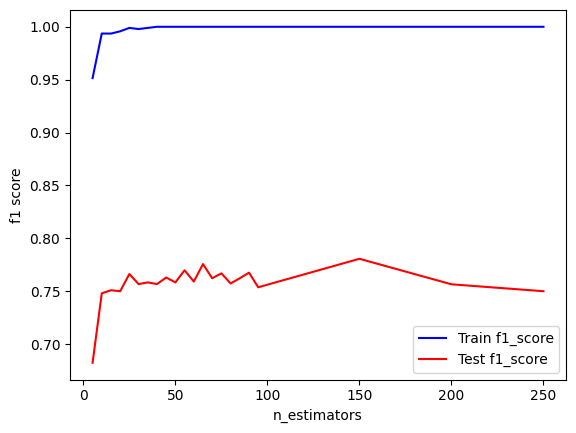

In [46]:
n_estimators = [x for x in range(5, 100, 5)] + [150,200,250]
get_train_test_plot({'n_estimators' : n_estimators})

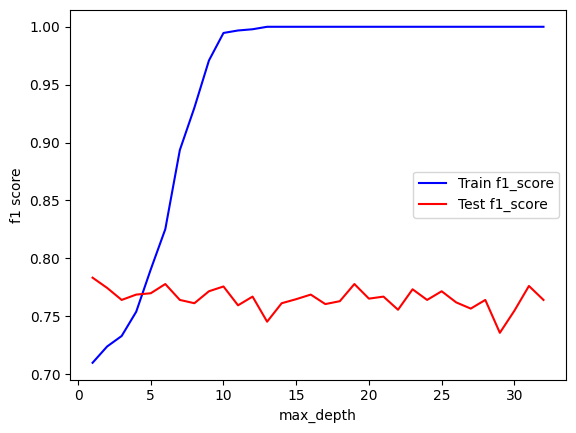

In [47]:
max_depth = [int(x) for x in range(1, 33)]
get_train_test_plot({'max_depth' : max_depth})

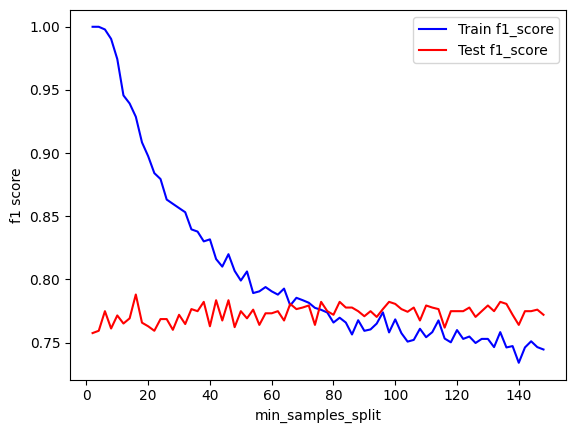

In [48]:
min_samples_split = [x for x in range(2, 150, 2)]
get_train_test_plot({'min_samples_split' : min_samples_split})

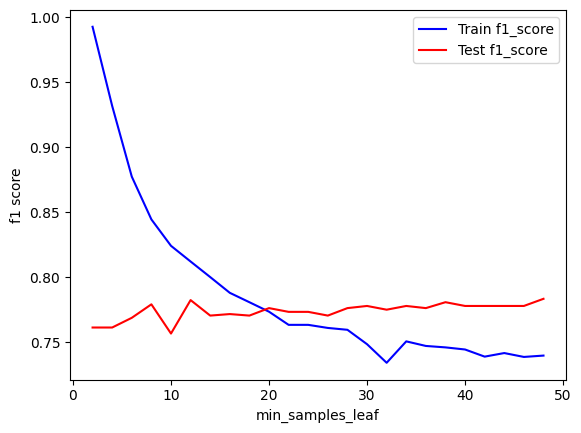

In [49]:
min_samples_leaf = [x for x in range(2,50, 2)]
get_train_test_plot({'min_samples_leaf' : min_samples_leaf})

Based on the observations in the plots above, I will not set a range of values for hypermeters to be optimized to get a model with lowest overfitting and underfitting ( balancing viance and bias )

In [50]:
# Number of trees in random forest
n_estimators = [10, 20, 30, 40, 50, 60, 70, 100, 150, 200]
# Number of features to consider at every split
max_features = ["sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in range(5, 20, 2)] + [None]

# Minimum number of samples required to split a node
min_samples_split = [x for x in range(20, 150, 10)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [x for x in range(5, 45, 5)]



# Create the random grid
param_grid = {
            'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
            }

pprint(param_grid)

{'max_depth': [5, 7, 9, 11, 13, 15, 17, 19, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40],
 'min_samples_split': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 100, 150, 200]}


I will be using RandomizedSearchCV since GridSearchCV took too much time for complete execution.

In [51]:
rs = RandomizedSearchCV(model, param_grid, n_jobs=-1, n_iter=2000, scoring='f1', cv=tscv, verbose=0, random_state=random_seed)
#rs = GridSearchCV(model, param_grid, n_jobs=-1, scoring='f1', cv=tscv)
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestClassifier(random_state=23),
                   n_iter=2000, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11, 13, 15, 17,
                                                      19, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [5, 10, 15, 20, 25,
                                                             30, 35, 40],
                                        'min_samples_split': [20, 30, 40, 50,
                                                              60, 70, 80, 90,
                                                              100, 110, 120,
                                                              130, 140],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 100, 150, 200]},
                   random_state=23, scoring='f1')

In [52]:
rs.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 11}

These are the new hyperparameters for our model.

In [53]:
# Best Params & Scores
print(f"Optimal Neighbours: {rs.best_params_}, Best Score: {round(rs.best_score_,4)}")

Optimal Neighbours: {'n_estimators': 150, 'min_samples_split': 30, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 11}, Best Score: 0.7074


## Tuned Model
Let’s now train and predict the model with the best search parameter

In [54]:
# Instantiate KNN model with search param
clf = RandomForestClassifier(**rs.best_params_, random_state=random_seed)
# Fit the model
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, min_samples_leaf=5, min_samples_split=30,
                       n_estimators=150, random_state=23)

In [55]:
# Cross validation score
score = cross_val_score(clf,X_train,y_train,cv=tscv)
print(f'Mean CV Score : {score.mean():0.4}')

Mean CV Score : 0.7387


In [56]:
df1.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Sign,PS,GAP,...,RSI_indictor_5,Willr_5,ADX_direction_5,ADX_5,OBV5,RSI_indictor_7,Willr_7,ADX_direction_7,ADX_7,OBV7
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-09 00:00:00-05:00,260.799988,263.609985,252.919998,261.500000,237.456238,283565300.0,0.014910,1.0,0.802620,0.012304,...,1.0,0.0,0.0,0.737351,-0.222228,1.0,0.0,0.0,0.743097,0.041049
2018-02-12 00:00:00-05:00,263.829987,267.010010,261.660004,265.339996,240.943130,143736000.0,0.014578,1.0,0.687848,0.008910,...,0.0,0.0,0.0,0.697970,-0.516910,0.0,0.0,0.0,0.713908,-0.049053
2018-02-13 00:00:00-05:00,263.970001,266.619995,263.309998,266.000000,241.542496,81223600.0,0.002484,1.0,0.812690,-0.005163,...,0.0,0.0,0.0,0.668130,-0.161883,0.0,0.0,0.0,0.691896,-0.222228
2018-02-14 00:00:00-05:00,264.309998,270.000000,264.299988,269.589996,244.802338,120735700.0,0.013406,1.0,0.928070,-0.006353,...,0.0,0.0,0.0,0.582443,-0.329259,0.0,0.0,0.0,0.634073,-0.516910
2018-02-15 00:00:00-05:00,271.570007,273.040009,268.769989,273.029999,247.926132,111200300.0,0.012680,1.0,0.997656,0.007345,...,0.0,0.0,0.0,0.469421,-0.575709,0.0,0.0,0.0,0.557655,-0.161883


Feature importance after tuning hyperparameters.

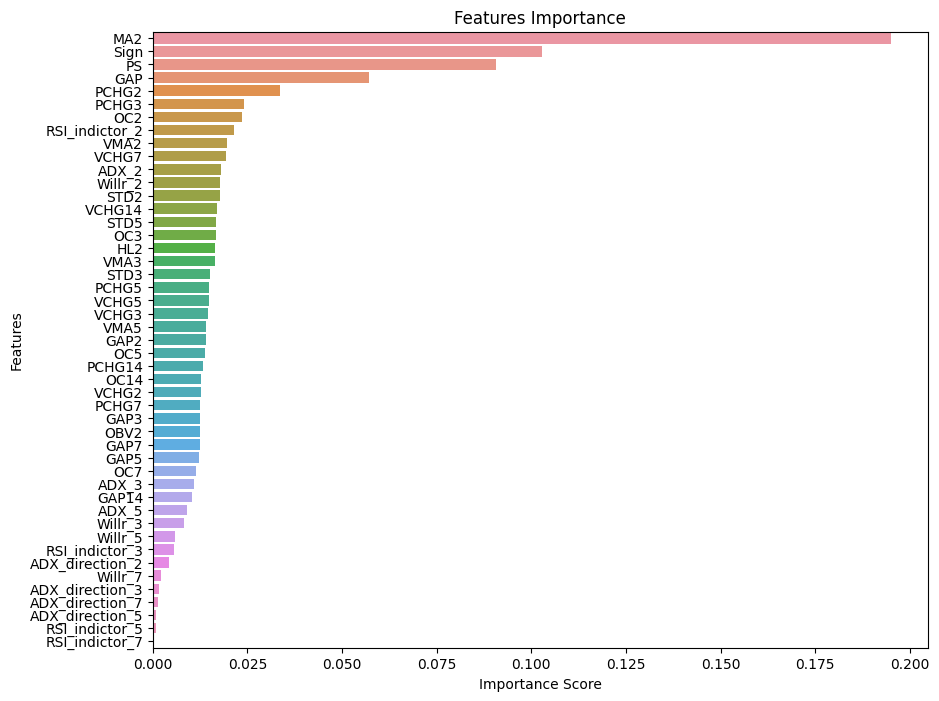

In [57]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': clf.feature_importances_,'Features': feature_names}).sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance')

if save_plot:
    plt.savefig('Features Importance tuned plot.png')

plt.show()

In [58]:

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

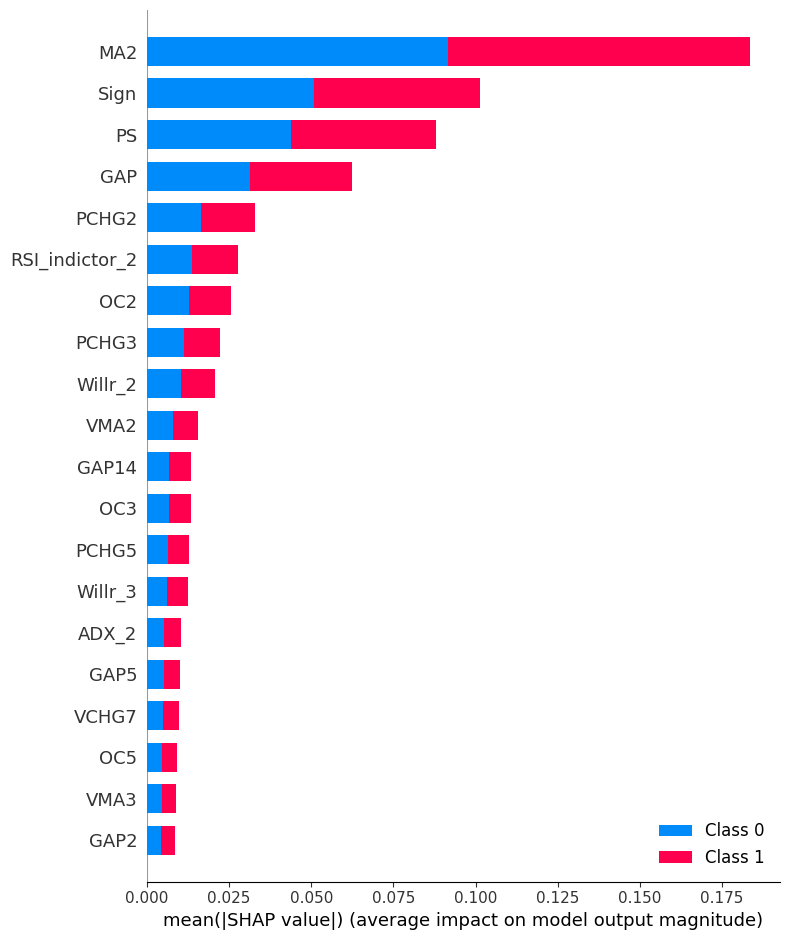

<Figure size 640x480 with 0 Axes>

In [59]:
# future importance summary
shap.summary_plot(shap_values, X_test, plot_type="bar")
if save_plot:
    plt.savefig('Features Importance SHAP tuned plot.png')

plt.show()

Now a plot of one of the trees from the model.

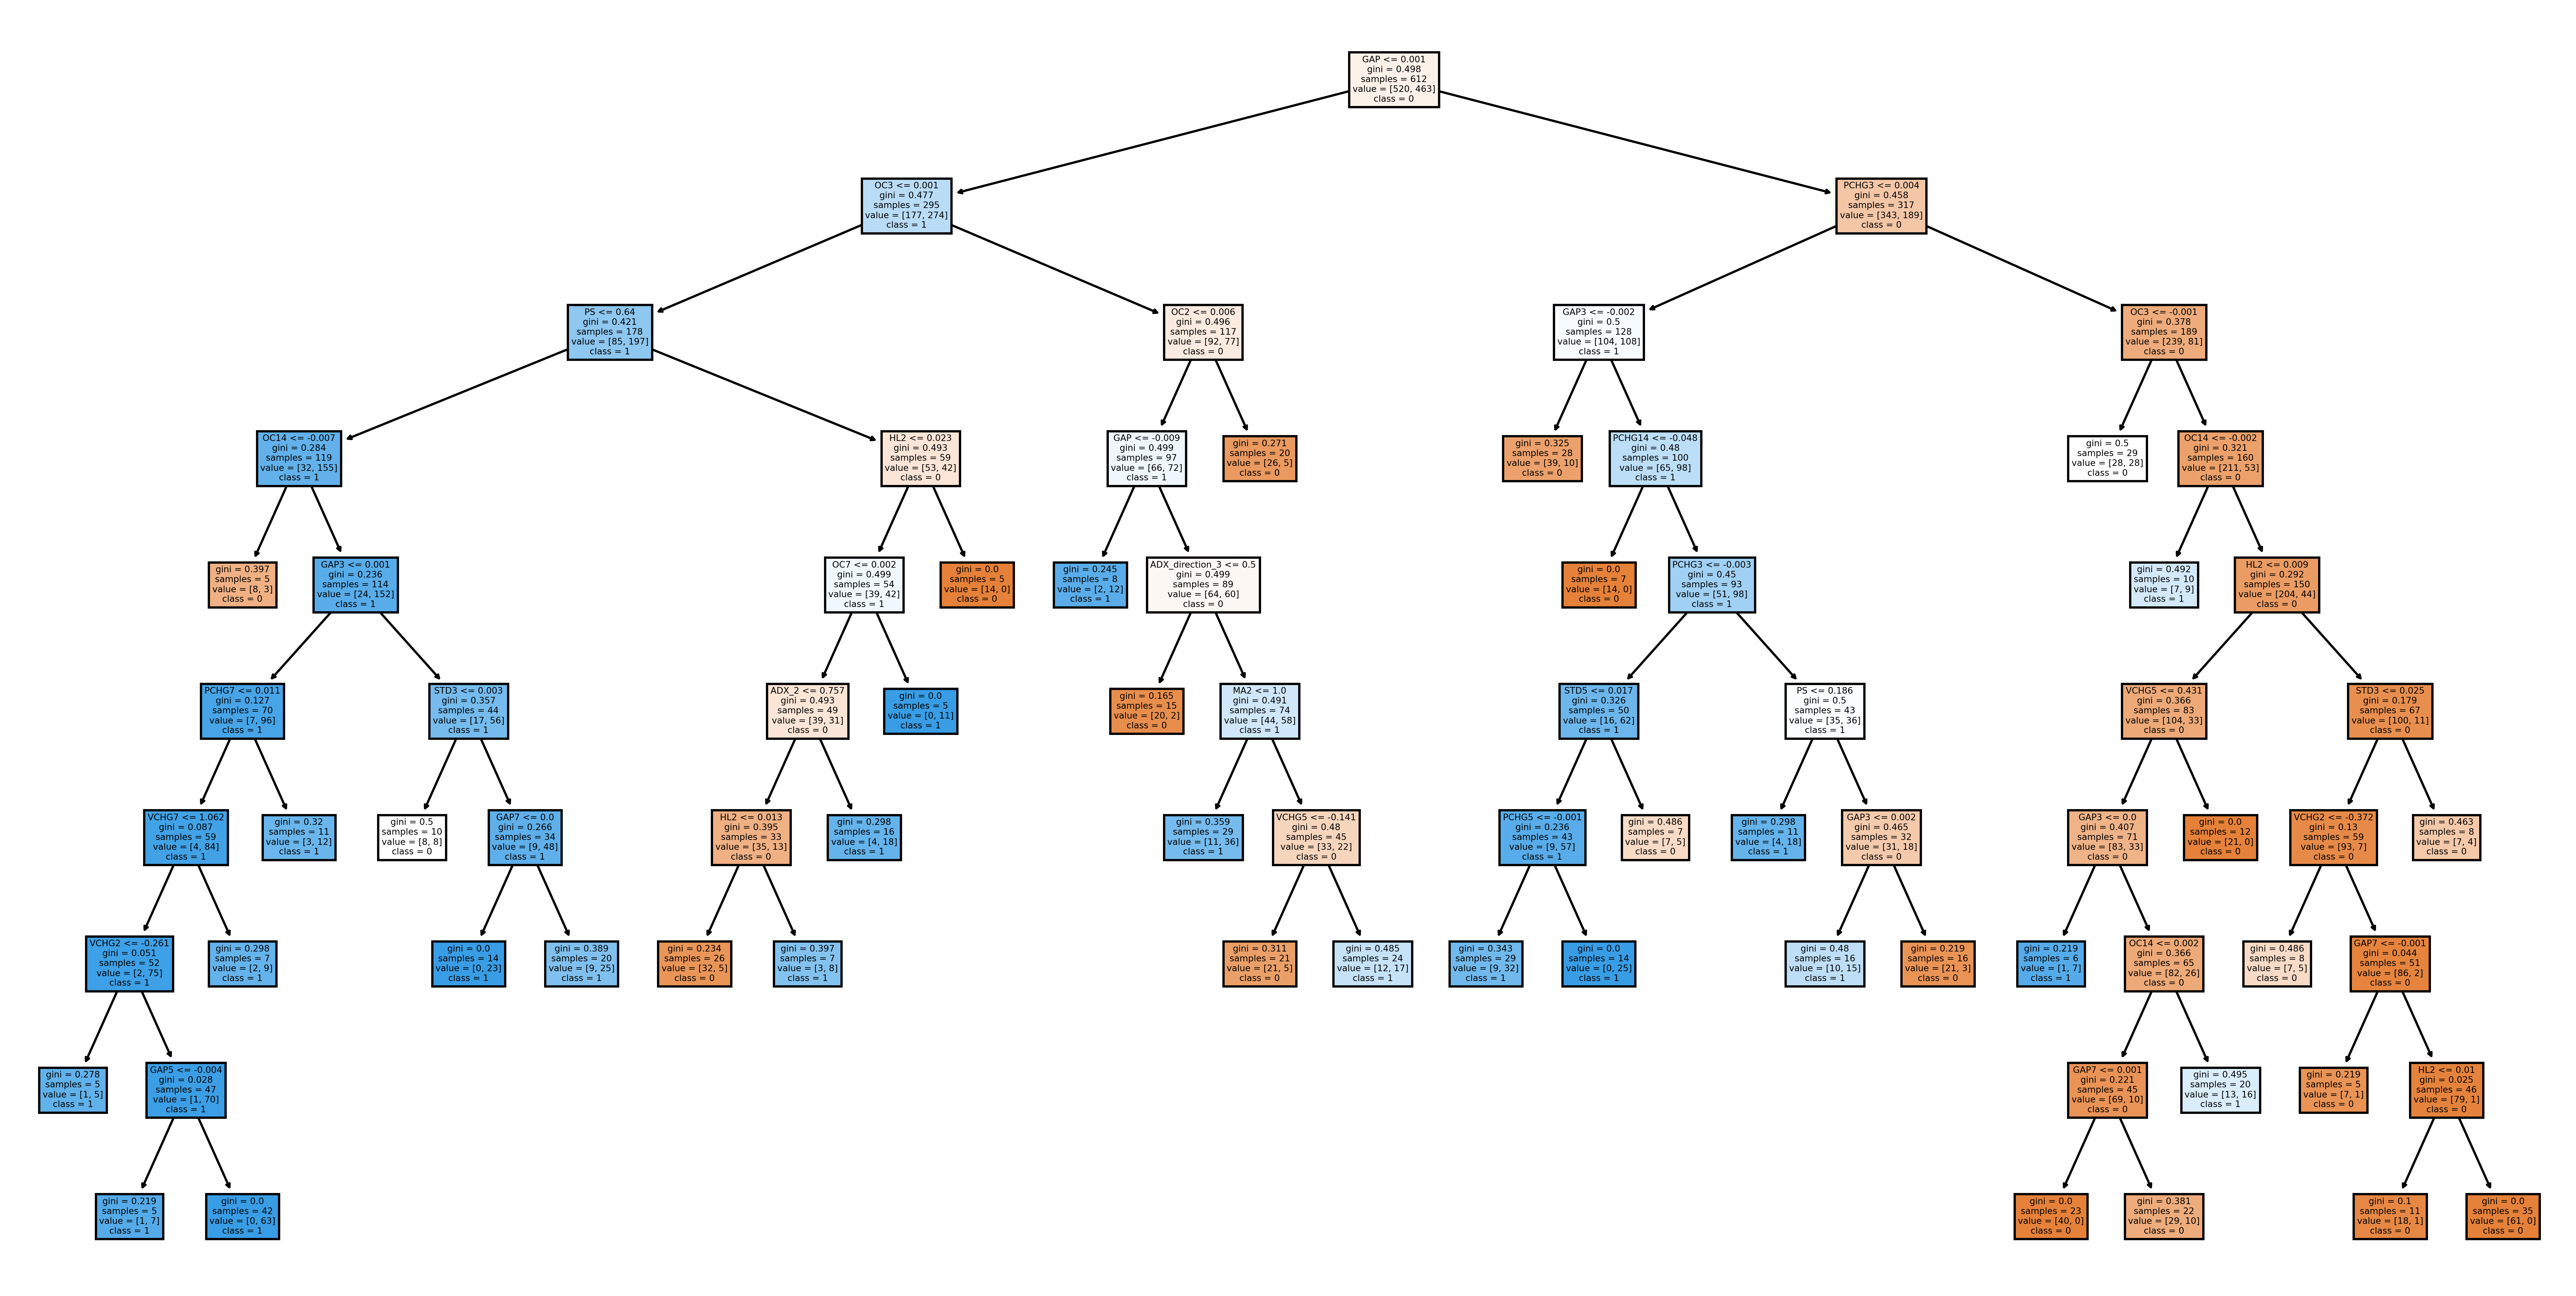

In [60]:
fn  =   model.feature_names_in_
cn  =   [ str(x) for x in model.classes_]

fig, axes = plt.subplots(figsize = (20,10), dpi=500)

tree.plot_tree(clf.estimators_[0],
                feature_names = fn, 
                class_names=cn,
                filled = True)
if save_plot:
    fig.savefig('Tree tuned plot.png')

fig.show()



## Step 7 : Metrics

In [61]:
# Predicting the test dataset
y_pred = clf.predict(X_test)
# Predict Probabilities
# y_proba = clf.predict_proba(X_test)[:,1]
# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.8342 
 Test Accuracy 		: 0.7602


Our train accuracy lowered from 1.0 to 0.83, while test accuracy went up from 0.74 to 0.76. This is because we tuned the model and reduced variance (overfitting). Even though the test accuracy improvement is small, since we reduced variance, this model should work better with generalized data compared to our base model.

In [75]:
train_acc_change = round(100 * (1-0.83)/1, 2)
test_acc_change = round(100 * (0.76-0.74)/0.74, 2)
print('Train accuracy change = {}%  \nTest accuracy change = {}%'.format(train_acc_change, test_acc_change))

Train accuracy change = 17.0%  
Test accuracy change = 2.7%


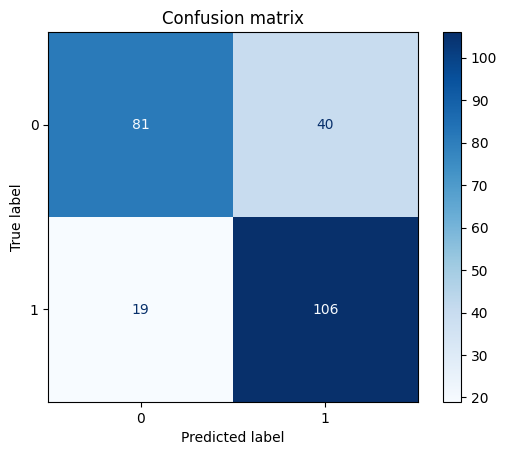

In [62]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
                                                    clf,
                                                    X_test,
                                                    y_test,
                                                    display_labels=model.classes_,
                                                    cmap=plt.cm.Blues
                                                    )
plt.title('Confusion matrix')

if save_plot:
    plt.savefig('Confusion matrix tuned plot.png')

plt.show()

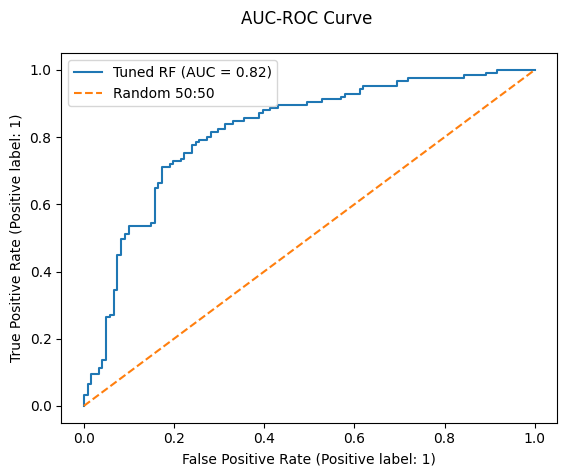

In [63]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
clf,
X_test,
y_test,
name='Tuned RF')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()

if save_plot:
    plt.savefig('AUC-ROC Curve tuned plot.png')

plt.show()

In [64]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73       121
           1       0.73      0.85      0.78       125

    accuracy                           0.76       246
   macro avg       0.77      0.76      0.76       246
weighted avg       0.77      0.76      0.76       246



In [65]:
(0.67-0.68)/0.68

-0.014705882352941188

Notes:
- accuracy has improved
- recall has improved

## Observations:
1. Test accuracy improved 4% as compared to earlier model.
2. Recall for class +1 improved by more than 7% as compared to earlier model while recall for class 0 decreased by 1%.
3. Model improved predictor for upside when compared to the downside
4. Class imbalance of 6.5% could be skewing the prediction.


## Trading Strategy
Let’s now define a trading strategy. We will use the predicted signal to buy or sell. We then
compare the result of this strategy with the buy and hold and visualize the performance of the
RandomForest Algorithm.

In [66]:
# Subsume into a new dataframe
df2 = df1.copy() # df[-len(X_test)
df2['Signal'] = clf.predict(X) # clf.predict(X_test) predicted signal to buy or sell

In [67]:
df2['Signal'].describe()

count    1229.000000
mean        0.497152
std         0.500195
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Signal, dtype: float64

In [68]:
# Daily Returns - Benchmark return
df2['Returns'] = np.log(df2['Adj Close']).diff().fillna(0)

# Strategy Returns 
df2['Strategy'] = df2['Returns'] * df2['Signal'].shift(1).fillna(0) # Strategy is based on what we predicted signal yesterday

# Localize index for pyfolio
df2.index = pd.to_datetime(df2.index, utc=True).tz_convert("UTC")

In [69]:
# Check the output
df2.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Returns,Sign,PS,GAP,...,ADX_direction_5,ADX_5,OBV5,RSI_indictor_7,Willr_7,ADX_direction_7,ADX_7,OBV7,Signal,Strategy
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-23 05:00:00+00:00,379.649994,383.059998,378.029999,382.910004,378.706665,59857300.0,0.005736,1.0,0.970180,-0.002810,...,0.0,0.321024,-2.238105,0.0,0.0,0.0,0.245485,-2.000541,0,0.005736
2022-12-27 05:00:00+00:00,382.790009,383.149994,379.649994,381.399994,377.213226,51638200.0,-0.003951,-1.0,0.500000,-0.000313,...,0.0,0.331913,-2.317983,0.0,0.0,0.0,0.254853,-2.118247,1,-0.000000
2022-12-28 05:00:00+00:00,381.329987,383.390015,376.420013,376.660004,372.525238,70911500.0,-0.012506,-1.0,0.034432,-0.000184,...,0.0,0.366173,-2.243556,0.0,1.0,0.0,0.276292,-2.238105,1,-0.012506
2022-12-29 05:00:00+00:00,379.630005,384.350006,379.079987,383.440002,379.230835,66970900.0,0.017840,1.0,0.827324,0.007885,...,0.0,0.372349,-2.165388,0.0,0.0,0.0,0.285614,-2.317983,0,0.017840
2022-12-30 05:00:00+00:00,380.640015,382.579987,378.429993,382.429993,378.231873,84022200.0,-0.002638,-1.0,0.963857,-0.007302,...,0.0,0.384090,-2.265509,0.0,0.0,0.0,0.296841,-2.243556,1,-0.000000


## Return analysis

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.75,2020-02-20,2020-03-12,2020-03-30,27
1,14.56,2018-09-21,2018-12-24,2019-02-22,111
2,12.07,2022-01-14,2022-06-14,2022-11-10,215
3,7.20,2018-02-27,2018-03-23,2018-05-01,45
4,6.46,2020-06-09,2020-06-11,2020-07-14,26


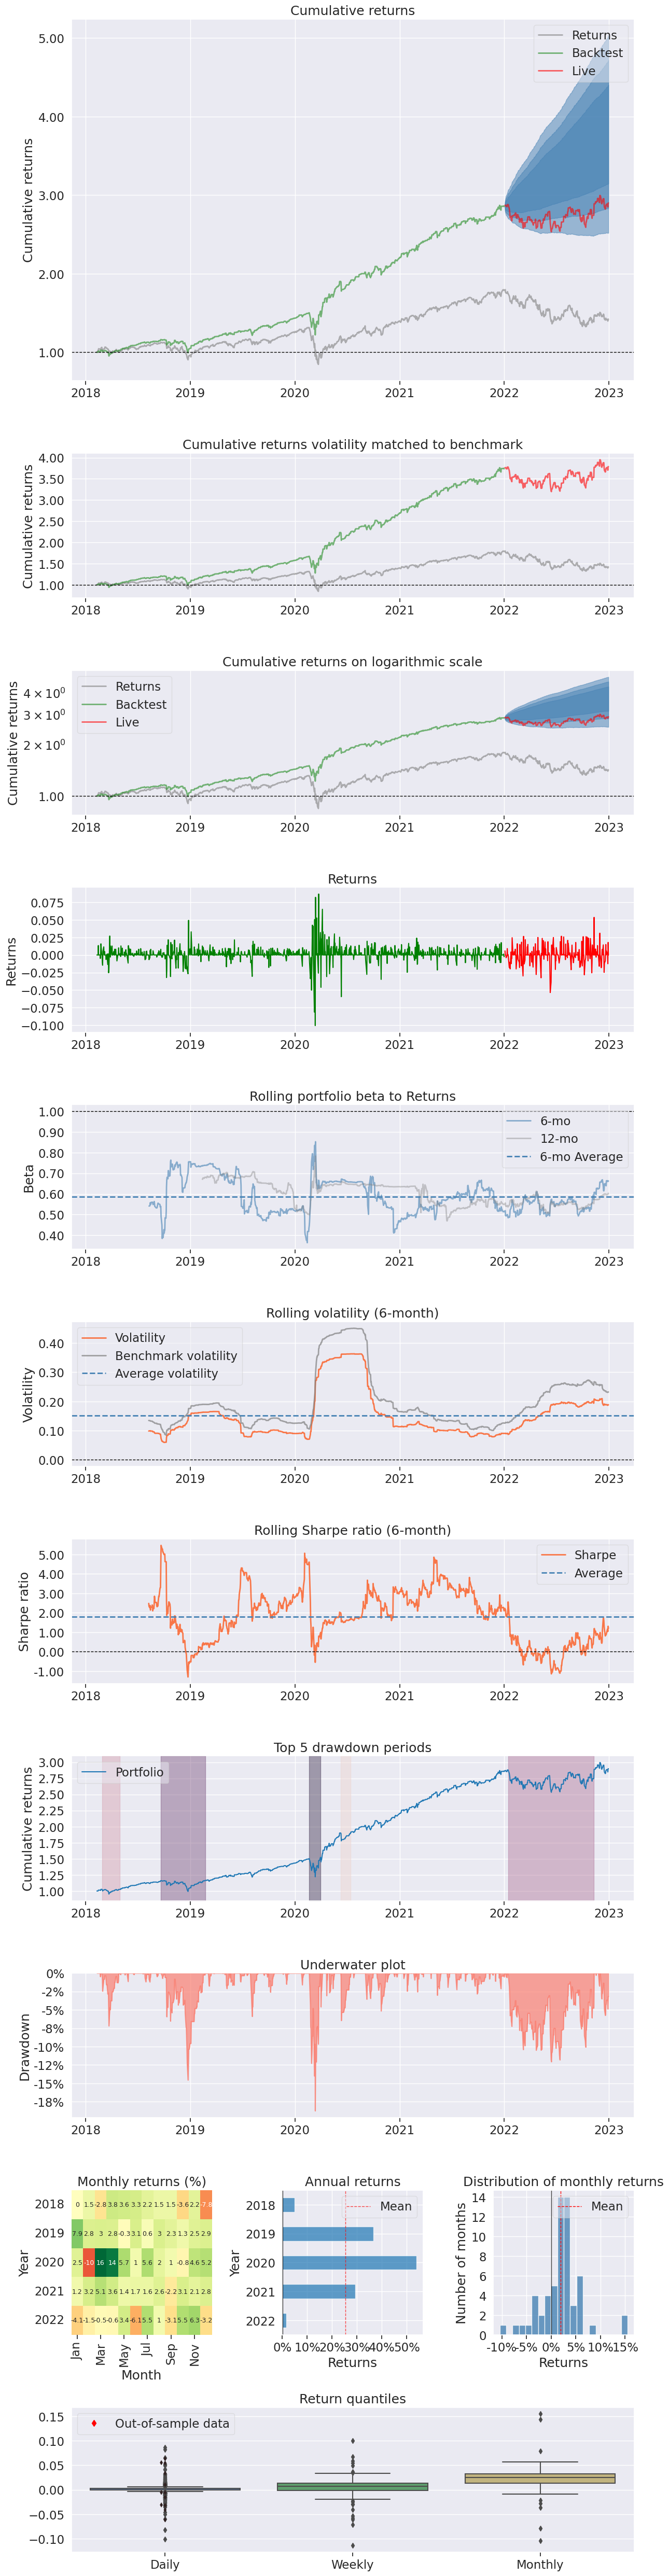

In [70]:

pf.create_returns_tear_sheet(df2['Strategy'], live_start_date=live_start_date, benchmark_rets=df2['Returns'])


if save_plot:
    plt.savefig('Strategy returns plot.png')

plt.show()


The mean in distribution of monthly returns is shifted right (>0) because we bettered the random guess, from random 50:50 (remember the roc curve).

## Observations
- The index SPY had -18.17 % returns in 2022. Our model was able to generate 1.59% for the same period during live testing which is good.
- We have an average Sharpe ratio close to 1.8.
- We have an annual average return of 24.395% for the 5 years and Cumulative returns	189.972%
- We observe a 18.75	drawdown during the period 2020-02-20 till 2020-03-12 which coincides with when the markets were after covid lockdowns.

In [71]:
time_for_execution = (time.time() - start_time)


In [72]:

time.strftime("%H:%M:%S", time.gmtime(time_for_execution))

'00:20:32'

In [73]:
print('Time for execution : {}'.format(time.strftime("%H:%M:%S", time.gmtime(time_for_execution))))

Time for execution : 00:20:32
